In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy import cluster


# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['model_dirs'] = {
    'BL_RIV2_test4': '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test4',}
params['CMA'] = 'CMA_0'
params['cells'] = ['277417', '321001', '195536']
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'
params['score_maps_path'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/BL_RIV2_test4'

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# Notas
- BL_t8 mide 08_H3K4ME3 usando 09_SRRM2
- The follow cells are overlaped
    - 277420
    - 195486

In [5]:
black_list = ['277420', '195486']

## 1.1.- Load dataset

In [6]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [7]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=371>,
 'train': <tfds.core.SplitInfo num_examples=2962>,
 'validation': <tfds.core.SplitInfo num_examples=370>}

In [8]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [9]:
metadata_df = tfds_metadata['metadata_df']
metadata_df.mapobject_id_cell = metadata_df.mapobject_id_cell.astype(str)
metadata_df

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
0,263042,263055,plate01,J16,0,0,0,0,4,0,plate01,J16,0,0,0,0,4,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,8401.0,39.610201,282.212391,14.709787,34.481345,122.127518,29.408288,48.079878,56.508154,71.844750,93.999276,108.771761,157.808500,85.331438,43.616172,323.670767,128.386167,134.658031,18.805303,57.414965,26.659837,122.008728,35.669525,62.715594,133.643428,77.230008,283.199741,6.970504,92.891114,280.267874,41.649294,350.631178,356.940289,10.909557,8.600135,1.771257,431.543626,7754.927152,9285.622307,0.553571,train
1,263043,263056,plate01,J16,0,0,0,0,5,0,plate01,J16,0,0,0,0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,12207.0,34.884746,249.743762,14.587963,33.729957,104.787060,25.446742,35.599046,54.977671,48.061287,90.354757,97.722536,145.751775,95.141995,43.284735,308.379265,118.856662,125.728553,14.722060,52.481306,21.451844,122.747143,30.401393,53.993867,124.670275,81.619971,272.290742,9.256049,120.165421,267.314880,39.224038,322.807908,387.219828,10.134157,7.880916,1.749512,461.474236,8818.934136,11041.621938,0.598214,test
2,263044,263057,plate01,J16,0,0,0,0,6,0,plate01,J16,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,15734.0,31.429217,184.722779,7.892179,19.263491,81.864454,23.929299,29.536900,39.606383,39.047856,77.348039,12.910413,149.859577,42.855445,25.530594,219.118552,102.575527,125.740665,5.120140,27.724444,24.187370,49.106275,29.276163,35.680201,85.295744,60.602490,232.305672,8.395510,124.383677,193.414682,36.115297,273.154826,252.115717,7.854372,8.116748,1.803605,372.570739,5740.956972,7330.808440,0.723214,train
3,263045,263058,plate01,J16,0,0,0,0,7,0,plate01,J16,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,DMSO,720.0,15767.0,43.349090,241.460906,18.110119,44.601291,122.976267,40.604674,48.760110,58.076779,77.012867,121.283321,104.755645,159.792550,84.807594,43.961097,319.584115,120.314566,120.470444,25.555966,60.243330,21.220701,140.246102,27.944981,60.354207,169.718381,102.371663,264.648847,10.370258,116.424263,268.396552,43.573547,351.399875,357.762600,10.338172,7.913029,1.773024,369.910382,8085.528636,9678.381810,0.660714,test
4,263047,263060,plate01,J16,0,0,0,0,9,0,plate01,J16,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,DMSO,720.0,11930.0,28.164459,149.241408,27.710272,72.874109,148.002903,51.391368,56.976488,116.255474,56.907744,66.943473,97.452245,187.995952,53.530015,60.917580,134.426297,121.980833,121.369045,59.501243,54.852952,26.389251,162.722979,36.026263,79.981471,237.625004,150.247531,255.964144,18.029298,188.560486,192.446750,66.494555,242.252349,174.614508,9.784177,8.899475,1.970130,552.887343,15128.646940,13469.590947,0.625000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,266516,266565,plate01,J12,5,4,0,0,44,0,plate01,J12,5,4,0,0,44,0,0.0,NaN,0.0,NaN,0.0,NaN,G2,184A1,normal,NaN,19401.0,38.974759,76.047797,17.563898,36.

In [13]:
channels_df = tfds_metadata['channels_df']

In [10]:
# Load model parameters
temp_key = list(params['model_dirs'].keys())[0]
temp_path = os.path.join(params['model_dirs'][temp_key], 'parameters.json')
with open(temp_path, 'r') as file:
    model_params = json.load(file)
print(model_params.keys())

dict_keys(['parameters_file_path', 'external_libs_path', 'model_name', 'custom_model_class', 'pre_training', 'dense_reg', 'conv_reg', 'bias_l2_reg', 'number_of_epochs', 'early_stop_patience', 'loss', 'learning_rate', 'BATCH_SIZE', 'verbose_level', 'model_path', 'basename', 'base_path', 'clean_model_dir', 'tf_ds_name', 'input_channels', 'shuffle_files', 'local_tf_datasets', 'random_horizontal_flipping', 'random_90deg_rotations', 'CenterZoom', 'CenterZoom_mode', 'Random_channel_intencity', 'RCI_dist', 'RCI_mean', 'RCI_stddev', 'RCI_rescale_cte', 'log_path', 'log_file', 'tensorboard', 'seed', 'disable_gpu', 'set_memory_growth', 'cell_size_ratio_mean', 'cell_size_ratio_stddev', 'cell_size_ratio_low_bound'])


In [14]:
# Get input_ids
selected_channels = model_params['input_channels']
n_channels = len(selected_channels)
input_ids = np.array(channels_df.set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = np.sort(input_ids.astype(np.int16))
input_channel_names = channels_df.sort_values(by='TFDS_channel_id').set_index('TFDS_channel_id').loc[range(n_channels)].name.values
print(input_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


## 1.2.- Load Model Data

In [15]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['model_dirs'].keys()):
    model_dir = params['model_dirs'][model]
    print('Reading predicted values for model: ', model)
    temp_path = os.path.join(model_dir, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
targets_df.mapobject_id_cell = targets_df.mapobject_id_cell.astype('string')
mask = targets_df.mapobject_id_cell.isin(np.array(params['cells']))
round(targets_df[mask], 2)

Reading predicted values for model:  BL_RIV2_test4


,y,mapobject_id_cell,set,perturbation,cell_cycle,y_hat_BL_RIV2_test4
3389,540.09,195536,test,normal,G2,485.31
3521,378.19,321001,test,normal,S,396.05
3588,133.04,277417,test,normal,G1,269.78


In [16]:
# Devide cell in Low TR medium and High
#low_per = targets_df.y.quantile(0.2)
#high_per = targets_df.y.quantile(0.8)
#print(low_per, high_per)
y_std = targets_df.y.std()
y_mean = targets_df.y.mean()
print(y_mean, y_std)
low_per = y_mean-y_std
high_per = y_mean+y_std
print(low_per, high_per)

mask_low = targets_df.y <= low_per
n_low = np.sum((mask_low).values)
mask_avg = (targets_df.y > low_per) & (targets_df.y < high_per)
n_avg = np.sum((mask_avg).values)
mask_high = targets_df.y >= high_per
n_high = np.sum((mask_high).values)
print(n_low, n_avg, n_high)
n_samples = n_low + n_avg + n_high
print(n_low/n_samples, n_avg/n_samples, n_high/n_samples)

# Save TR level
targets_df['TR_Level'] = 'Medium_TR'
temp_idxs = targets_df[mask_low].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'Low_TR'
temp_idxs = targets_df[mask_high].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'High_TR'
targets_df

377.2833369803886 60.71855957335795
316.56477740703065 438.0018965537465
532 2626 545
0.14366729678638943 0.7091547394004861 0.1471779638131245


,y,mapobject_id_cell,set,perturbation,cell_cycle,y_hat_BL_RIV2_test4,TR_Level
0,337.603180,305670,train,DMSO,G1,393.687317,Medium_TR
1,436.179108,248989,train,DMSO,G1,432.883423,Medium_TR
2,344.612427,212764,train,normal,G1,340.201813,Medium_TR
3,397.731262,383254,train,normal,G1,351.875275,Medium_TR
4,251.880371,287059,train,DMSO,G1,375.951721,Low_TR
...,...,...,...,...,...,...,...
3698,400.196350,321028,test,normal,G1,418.039886,Medium_TR
3699,414.214355,194787,test,normal,S,404.132172,Medium_TR
3700,354.966553,259718,test,normal,G1,350.943604,Medium_TR
3701,425.607788,351947,test,normal,G1,344.580719,Medium_TR


## 1.3.- Load score maps info

In [17]:
# load score maps metadata
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
temp_path = os.path.join(params['score_maps_path'], 'score_map_stddev.csv')
score_map_stddev = pd.read_csv(temp_path)
score_map_stddev.mapobject_id_cell = score_map_stddev.mapobject_id_cell.astype('string')
# Add more info
score_map_stddev = score_map_stddev.merge(targets_df,
                                          left_on='mapobject_id_cell',
                                          right_on='mapobject_id_cell',
                                          how='left')
score_map_stddev

,00_DAPI,07_H2B,01_CDK9_pT186,03_CDK9,05_GTF2B,07_SETD1A,08_H3K4me3,09_SRRM2,10_H3K27ac,11_KPNA2_MAX,12_RB1_pS807_S811,13_PABPN1,14_PCNA,15_SON,16_H3,17_HDAC3,19_KPNA1_MAX,20_SP100,21_NCL,01_PABPC1,02_CDK7,03_RPS6,05_Sm,07_POLR2A,09_CCNT1,10_POL2RA_pS2,11_PML,12_YAP1,13_POL2RA_pS5,15_U2SNRNPB,18_NONO,20_ALYREF,21_COIL,Total_cell_stddev,Model,mapobject_id_cell,y,set,perturbation,cell_cycle,y_hat_BL_RIV2_test4,TR_Level
0,0.021754,0.026529,0.034256,0.023857,0.046141,0.049208,0.030868,0.047396,0.017080,0.019650,0.020092,0.039375,0.030082,0.029414,0.024536,0.038465,0.014033,0.022731,0.034001,0.013857,0.023052,0.032130,0.029906,0.032766,0.024469,0.082783,0.020691,0.018230,0.030914,0.032267,0.031785,0.021933,0.035747,394.17322,BL_RIV2_test4,305670,337.603180,train,DMSO,G1,393.687317,Medium_TR
1,0.020187,0.035958,0.050179,0.034767,0.049775,0.042416,0.032182,0.038114,0.016155,0.022010,0.017576,0.034342,0.017154,0.016386,0.025218,0.043587,0.023486,0.017619,0.038527,0.018933,0.023193,0.043794,0.034108,0.026417,0.022609,0.072789,0.015469,0.021051,0.032337,0.031487,0.037531,0.017940,0.026706,556.39990,BL_RIV2_test4,248989,436.179108,train,DMSO,G1,432.883423,Medium_TR
2,0.018894,0.026342,0.027377,0.024820,0.054287,0.034398,0.025356,0.042189,0.019616,0.022974,0.015177,0.037974,0.024109,0.030445,0.036172,0.028468,0.016492,0.018544,0.058972,0.020592,0.017053,0.038208,0.036632,0.022429,0.025903,0.074867,0.023934,0.013758,0.033574,0.039373,0.023196,0.028319,0.039556,298.80084,BL_RIV2_test4,212764,344.612427,train,normal,G1,340.201813,Medium_TR
3,0.018316,0.023719,0.025623,0.026080,0.054002,0.034795,0.026364,0.044107,0.020712,0.020142,0.016356,0.035735,0.024801,0.029357,0.028014,0.025221,0.016634,0.018969,0.057283,0.025418,0.016562,0.036844,0.042424,0.021965,0.029334,0.073191,0.027087,0.016241,0.031316,0.038380,0.025405,0.026298,0.043304,251.42209,BL_RIV2_test4,383254,397.731262,train,normal,G1,351.875275,Medium_TR
4,0.023178,0.033219,0.032957,0.025359,0.039486,0.038332,0.028650,0.042185,0.023298,0.032004,0.016112,0.039168,0.024097,0.020038,0.034207,0.048472,0.023686,0.019167,0.030599,0.022228,0.022879,0.047623,0.027645,0.026608,0.020016,0.094904,0.018076,0.012405,0.029124,0.028067,0.028341,0.020580,0.027289,348.70270,BL_RIV2_test4,287059,251.880371,train,DMSO,G1,375.951721,Low_TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,0.020526,0.028627,0.042198,0.026439,0.043433,0.048290,0.026681,0.047105,0.016330,0.018655,0.015792,0.035816,0.017752,0.030277,0.025025,0.030446,0.015282,0.023721,0.043803,0.018461,0.017380,0.031951,0.039233,0.033939,0.029440,0.058676,0.025567,0.016517,0.030267,0.036155,0.043080,0.029357,0.033779,598.31280,BL_RIV2_test4,321028,400.196350,test,normal,G1,418.039886,Medium_TR
3699,0.024525,0.026005,0.031450,0.022771,0.045625,0.042689,0.025481,0.049762,0.017878,0.021180,0.018274,0.042016,0.035363,0.029283,0.025315,0.030896,0.020279,0.024166,0.035620,0.017220,0.023780,0.034727,0.029686,0.031254,0.022251,0.078228,0.023598,0.013174,0.032316,0.031853,0.028536,0.023988,0.040812,347.03976,BL_RIV2_test4,194787,414.214355,test,normal,S,404.132172,Medium_TR
3700,0.021166,0.031862,0.028092,0.024746,0.047955,0.031430,0.024385,0.048991,0.019335,0.024752,0.016835,0.038848,0.026474,0.029099,0.034523,0.028373,0.015048,0.019461,0.049381,0.021956,0.015772,0.034107,0.033241,0.021751,0.025975,0.083432,0.026064,0.014208,0.032721,0.039311,0.023372,0.027593,0.039743,249.67712,BL_RIV2_test4,259718,354.966553,test,normal,G1,350.943604,Medium_TR
3701,0.018727,0.023733,0.027946,0.028943,0.052917,0.037200,0.026256,0.041784,0.017151,0.020195,0.017282,0.038032,0.021608,0.036266,0.026807,0.027582,0.016527,0.021582,0.051445,0.023350,0.017243,0.039132,0.041125,0.024260,0.029448,0.076565,0.023174,0.016009,0.028436,0.036073,0.028030,0.023707,0.041462,286.59564,BL_RIV2_test4,351947,425.607788,test,normal,G1,344.580719,Medium_TR


Opening cell: 195536, 1/3
['test']
Opening cell: 321001, 2/3
['test']
Opening cell: 277417, 3/3
['test']


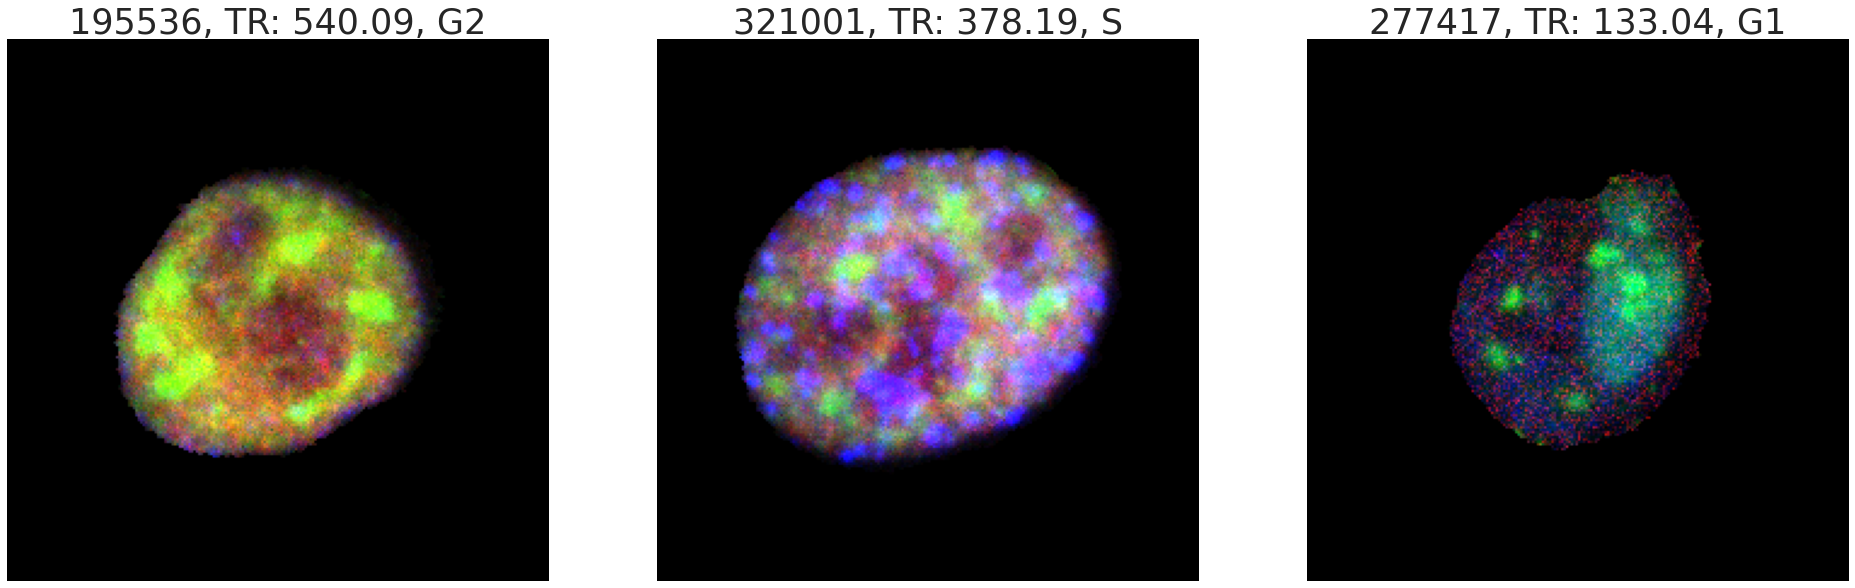

In [18]:
def move_img_into_0_1(temp_img, temp_mask):
    min_vals = temp_img[temp_mask].min(axis=0)
    max_vals = temp_img[temp_mask].max(axis=0)
    
    temp_img[temp_mask] = (temp_img[temp_mask] - min_vals) / (max_vals - min_vals)
    
    return temp_img

final_ids = ['277417', '321001', '195536'] # this are from the test data

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(final_ids)

plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
cell_count = 0
cells = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in final_ids:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells[cell_id+'_img'] = cell['image'].numpy()
            cells[cell_id+'_img'] = cells[cell_id+'_img'][:,:,input_ids].astype(np.float32)
            
            cells[cell_id+'_mask'] = cell['image'].numpy()
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'][:,:,-1]
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)
            
            cells[cell_id+'_tr'] = cell['target'].numpy()[0]
            
            # load score map
            temp_path = os.path.join(score_maps_dir, cell_id+'.npy')
            cells[cell_id+'_sm'] = np.load(temp_path)
            
            # Plot cells
            temp_img = copy.deepcopy(cells[cell_id+'_img'][:,:,10:13])
            temp_img = move_img_into_0_1(temp_img, cells[cell_id+'_mask'])
            
            plt.subplot(1, n_cells, cell_count)

            # Get TR
            TR = cells[cell_id+'_tr']
            # get cc
            mask = targets_df.mapobject_id_cell == cell_id
            cc = targets_df[mask].cell_cycle.values[0]
            print(targets_df[mask].set.values)

            nn_inter.plot_cell(img=temp_img, title=cell_id+', TR: '+str(round(TR, 2))+', '+cc, title_fontsize=35)

In [43]:
from scipy import ndimage
from scipy.spatial.distance import directed_hausdorff

def compute_channel_difference_matrix(temp_sm, metric='mae'):
    n_channels = temp_sm.shape[-1]
    dist_mtx = np.zeros((n_channels, n_channels))
    for i in range(n_channels):
        for j in range(n_channels):
            if metric == 'mae':
                dist_mtx[i,j] = np.sum(np.abs(temp_sm[:,:,i] - temp_sm[:,:,j]))
            elif metric == 'hausdorff':
                dist_mtx[i,j] = directed_hausdorff(temp_sm[:,:,i], temp_sm[:,:,j])[0]
    
    # normalize values
    norm_param = dist_mtx.sum()
    dist_mtx /= norm_param
    
    return dist_mtx

def apply_gaussin_filter(img=None,  sigma=1):
    return ndimage.gaussian_filter(img, sigma)

def standardize_img(img, img_mask):
    channel_mean = img[img_mask].mean(axis=0)
    channel_stddev = img[img_mask].std(axis=0)

    img[img_mask] = img[img_mask] - channel_mean
    img[img_mask] = img[img_mask] / channel_stddev
    
    return img

def apply_percentile_clipping(img, img_mask, p=98):

    percentile_vector = np.percentile(img[img_mask], q=p, axis=0)

    n_channels = img.shape[-1]
    for c in range(n_channels):
        mask = (img[:,:,c] >= percentile_vector[c])
        img[:,:,c][mask] = percentile_vector[c]
        
    return img

def get_channels_dist(c1, c2, cell_mask, metric):
    N = cell_mask.sum()
    if metric == 'mae':
        return (1 / N) * np.sum(np.abs(c1 - c2))
    elif metric == 'hausdorff':
        return directed_hausdorff(c1, c2)[0]
    
def get_score_map_similarity(temp_score, temp_cell_img, cell_mask, metric='mae'):
    INF = np.inf
    n_channels =  temp_score.shape[-1]
    # similarity between score_map channels and score_map channels
    top_sim_sm_channel_id_dict = {}
    top_sim_sm_channel_dist_dict = {}
    # similarity between score_map channels and cell_img channels
    top_sim_channel_id_dict = {}
    most_sim_channel_dist = {}
    # dataframes to store score map channel dist
    temp_sm_to_sm = {}
    temp_sm_to_ci = {}
    
    for key in range(3):
        top_sim_sm_channel_id_dict[key] = []
        top_sim_sm_channel_dist_dict[key] = []
        
        top_sim_channel_id_dict[key] = []
        most_sim_channel_dist[key] = []
    
    for i in range(n_channels):
        sm_chanel_dist = []
        chanel_dist = []
        for j in range(n_channels):
            if i == j:
                # distance between a channel and itself is 0, therefore assign it INF
                sm_chanel_dist.append(INF)
            else:
                sm_chanel_dist.append(get_channels_dist(temp_score[:,:,i], temp_score[:,:,j], cell_mask, metric))
            # distances between the score_map channel j and cell_img channels
            chanel_dist.append(get_channels_dist(temp_score[:,:,i], temp_cell_img[:,:,j], cell_mask, metric))
            
        for key in range(3):
            # save the most similar score_map channel to channel i
            top_sim_sm_channel_id_dict[key].append(np.argsort(sm_chanel_dist)[key])
            top_sim_sm_channel_dist_dict[key].append(np.sort(sm_chanel_dist)[key])
            # save the most similar cell_img channel to score_map channel i
            top_sim_channel_id_dict[key].append(np.argsort(chanel_dist)[key])
            most_sim_channel_dist[key].append(np.sort(chanel_dist)[key])
    
    columns = [cn+'_idx' for cn in input_channel_names] + [cn+'_dist' for cn in input_channel_names]
    for key in range(3):
        temp_arr = np.array(top_sim_sm_channel_id_dict[key] + top_sim_sm_channel_dist_dict[key]).reshape((1, -1))
        temp_sm_to_sm[key] = pd.DataFrame(temp_arr, columns=columns)
        temp_arr = np.array(top_sim_channel_id_dict[key] + most_sim_channel_dist[key]).reshape((1, -1))
        temp_sm_to_ci[key] = pd.DataFrame(temp_arr, columns=columns)
    
    return temp_sm_to_sm, temp_sm_to_ci

def preprocess_img(temp_img, temp_mask, stddev=1):
    #temp_img = apply_gaussin_filter(temp_img, stddev)
    return standardize_img(temp_img, temp_mask)

def preprocess_sm(temp_score, temp_mask, stddev=1):
    temp_score = apply_percentile_clipping(temp_score, temp_mask, 98)
    temp_score = apply_gaussin_filter(temp_score, stddev)
    return standardize_img(temp_score, temp_mask)

def get_sm_clusters(temp_sm, n_clusters=[3]):
        
    distance_matrix = compute_channel_difference_matrix(temp_sm)
    temp_df = pd.DataFrame(distance_matrix, columns=input_channel_names)
    temp_df['c_name'] = input_channel_names
    temp_df = temp_df.set_index('c_name')
    
    Z = cluster.hierarchy.linkage(temp_df, method='average')
    cutree = cluster.hierarchy.cut_tree(Z, n_clusters=n_clusters)
    
    return cutree

def plot_clustermap(dist_mtx, channels_df):
    n_channels = dist_mtx.shape[-1]
    channel_names = channels_df.sort_values(by='TFDS_channel_id')
    mask = channel_names.TFDS_channel_id.isin(range(n_channels))
    channel_names = channel_names[mask].name.values

    temp_df = pd.DataFrame(dist_mtx, columns=channel_names)
    temp_df['c_name'] = channel_names
    temp_df = temp_df.set_index('c_name')

    sns.clustermap(
            data=temp_df,
            #vmin=0,
            #vmax=1,
            cmap=plt.cm.Blues,
            cbar=True,
            annot=True,
            figsize=(20,20)
        )
    plt.savefig('./Plot/temp.jpg', bbox_inches='tight', pad_inches=0)

In [21]:
metric = 'mae'
stddev = 1
distance_df = pd.DataFrame()

#mask = tfds_metadata['metadata_df'].set == 'test'
#cells_to_process = tfds_metadata['metadata_df'][mask].mapobject_id_cell.unique().astype('str')
cells_to_process = tfds_metadata['metadata_df'].mapobject_id_cell.unique().astype('str')

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
n_cells = len(cells_to_process)
dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
cell_count = 0
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in cells_to_process:
            cell_count += 1
            print('Loading cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cell_mask = cell['image'].numpy()
            cell_mask = cell_mask[:,:,-1]
            cell_mask = cell_mask.astype(np.bool)
            
            # load score map
            temp_path = os.path.join(score_maps_dir, cell_id+'.npy')
            score_map = np.load(temp_path)
            
            # get channel similarity matrix
            # preprocess
            score_map = preprocess_sm(score_map, cell_mask, stddev)
            
            distance_matrix = compute_channel_difference_matrix(score_map)
            temp_df = pd.DataFrame(distance_matrix, columns=input_channel_names)
            temp_df['mapobject_id_cell'] = cell_id
            distance_df = pd.concat((distance_df, temp_df), axis=0, ignore_index=True)

Loading cell: 305670, 1/3703
Loading cell: 248989, 2/3703
Loading cell: 212764, 3/3703
Loading cell: 383254, 4/3703
Loading cell: 287059, 5/3703
Loading cell: 226855, 6/3703
Loading cell: 366430, 7/3703
Loading cell: 266507, 8/3703
Loading cell: 337246, 9/3703
Loading cell: 235351, 10/3703
Loading cell: 305662, 11/3703
Loading cell: 307724, 12/3703
Loading cell: 221647, 13/3703
Loading cell: 194797, 14/3703
Loading cell: 260099, 15/3703
Loading cell: 321007, 16/3703
Loading cell: 215865, 17/3703
Loading cell: 305667, 18/3703
Loading cell: 258520, 19/3703
Loading cell: 195221, 20/3703
Loading cell: 350656, 21/3703
Loading cell: 257458, 22/3703
Loading cell: 359335, 23/3703
Loading cell: 195549, 24/3703
Loading cell: 329080, 25/3703
Loading cell: 202822, 26/3703
Loading cell: 359020, 27/3703
Loading cell: 319175, 28/3703
Loading cell: 256525, 29/3703
Loading cell: 287403, 30/3703
Loading cell: 373523, 31/3703
Loading cell: 351026, 32/3703
Loading cell: 319183, 33/3703
Loading cell: 26854

In [26]:
# Save data
#temp_name = os.path.join('./Data/Clip_gaus_std', 'distance_matrix.csv')
#with open(temp_name, 'w') as file:
#    distance_df.to_csv(file, index=False)

temp_name = os.path.join('./Data/Clip_gaus_std', 'distance_matrix.csv')
with open(temp_name, 'r') as file:
    distance_df = pd.read_csv(file)

In [61]:
distance_df.mapobject_id_cell = distance_df.mapobject_id_cell.astype(str)
distance_df

,00_DAPI,07_H2B,01_CDK9_pT186,03_CDK9,05_GTF2B,07_SETD1A,08_H3K4me3,09_SRRM2,10_H3K27ac,11_KPNA2_MAX,12_RB1_pS807_S811,13_PABPN1,14_PCNA,15_SON,16_H3,17_HDAC3,19_KPNA1_MAX,20_SP100,21_NCL,01_PABPC1,02_CDK7,03_RPS6,05_Sm,07_POLR2A,09_CCNT1,10_POL2RA_pS2,11_PML,12_YAP1,13_POL2RA_pS5,15_U2SNRNPB,18_NONO,20_ALYREF,21_COIL,mapobject_id_cell,TR_Level_x,cell_cycle_x,TR_Level_y,cell_cycle_y
0,0.000000,0.000379,0.000525,0.000612,0.000626,0.000638,0.000592,0.000523,0.000843,0.000958,0.000503,0.000491,0.000609,0.000949,0.001114,0.000767,0.000787,0.001474,0.001843,0.001436,0.001178,0.001413,0.001223,0.000849,0.000730,0.000742,0.000750,0.000806,0.001111,0.001065,0.000819,0.000783,0.000866,305670,NaN,NaN,Medium_TR,G1
1,0.000379,0.000000,0.000266,0.000529,0.000658,0.000714,0.000664,0.000506,0.000707,0.000796,0.000371,0.000506,0.000568,0.000862,0.001008,0.000672,0.000718,0.001401,0.001728,0.001332,0.001138,0.001367,0.001197,0.000878,0.000777,0.000761,0.000739,0.000643,0.000925,0.000902,0.000677,0.000688,0.000828,305670,NaN,NaN,Medium_TR,G1
2,0.000525,0.000266,0.000000,0.000372,0.000545,0.000668,0.000645,0.000515,0.000786,0.000865,0.000426,0.000502,0.000546,0.000873,0.001043,0.000678,0.000628,0.001286,0.001633,0.001229,0.001032,0.001250,0.001075,0.000794,0.000731,0.000705,0.000662,0.000597,0.000921,0.000875,0.000643,0.000640,0.000780,305670,NaN,NaN,Medium_TR,G1
3,0.000612,0.000529,0.000372,0.000000,0.000295,0.000568,0.000607,0.000565,0.000838,0.000908,0.000507,0.000542,0.000528,0.000782,0.001003,0.000670,0.000618,0.001275,0.001630,0.001224,0.001014,0.001228,0.001025,0.000745,0.000732,0.000714,0.000639,0.000583,0.000888,0.000809,0.000568,0.000593,0.000764,305670,NaN,NaN,Medium_TR,G1
4,0.000626,0.000658,0.000545,0.000295,0.000000,0.000341,0.000448,0.000576,0.000936,0.001030,0.000565,0.000517,0.000520,0.000813,0.001094,0.000780,0.000674,0.001339,0.001765,0.001341,0.001041,0.001236,0.000996,0.000637,0.000624,0.000641,0.000621,0.000727,0.001015,0.000912,0.000616,0.000624,0.000759,305670,NaN,NaN,Medium_TR,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000762,0.001004,0.001047,0.000831,0.000738,0.000947,0.001125,0.001026,0.000634,0.000525,0.000724,0.000885,0.000703,0.000538,0.000553,0.000398,0.000689,0.001257,0.001487,0.001285,0.001139,0.001310,0.001303,0.001303,0.001264,0.001174,0.001065,0.000619,0.000000,0.000277,0.000592,0.000790,0.001168,224150,NaN,NaN,High_TR,G1
122195,0.000669,0.000870,0.000899,0.000696,0.000594,0.000772,0.000975,0.000912,0.000629,0.000672,0.000651,0.000803,0.000655,0.000677,0.000747,0.000483,0.000646,0.001203,0.001442,0.001227,0.001044,0.001197,0.001137,0.001139,0.001152,0.001096,0.001033,0.000681,0.000277,0.000000,0.000355,0.000668,0.001078,224150,NaN,NaN,High_TR,G1
122196,0.000545,0.000650,0.000671,0.000473,0.000442,0.000572,0.000785,0.000757,0.000729,0.000887,0.000624,0.000693,0.000673,0.000930,0.001037,0.000649,0.000554,0.001071,0.001347,0.001142,0.000893,0.001023,0.000887,0.000885,0.000939,0.000908,0.000886,0.000667,0.000592,0.000355,0.000000,0.000424,0.000871,224150,NaN,NaN,High_TR,G1
122197,0.000662,0.000794,0.000823,0.000559,0.000509,0.000724,0.000920,0.000869,0.000820,0.000915,0.000641,0.000701,0.000700,0.001018,0.001142,0.000803,0.000686,0.001023,0.001331,0.001157,0.000926,0.001059,0.000935,0.001008,0.001004,0.000934,0.000911,0.000738,0.000790,0.000668,0.000424,0.000000,0.000486,224150,NaN,NaN,High_TR,G1


<AxesSubplot:xlabel='value', ylabel='Density'>

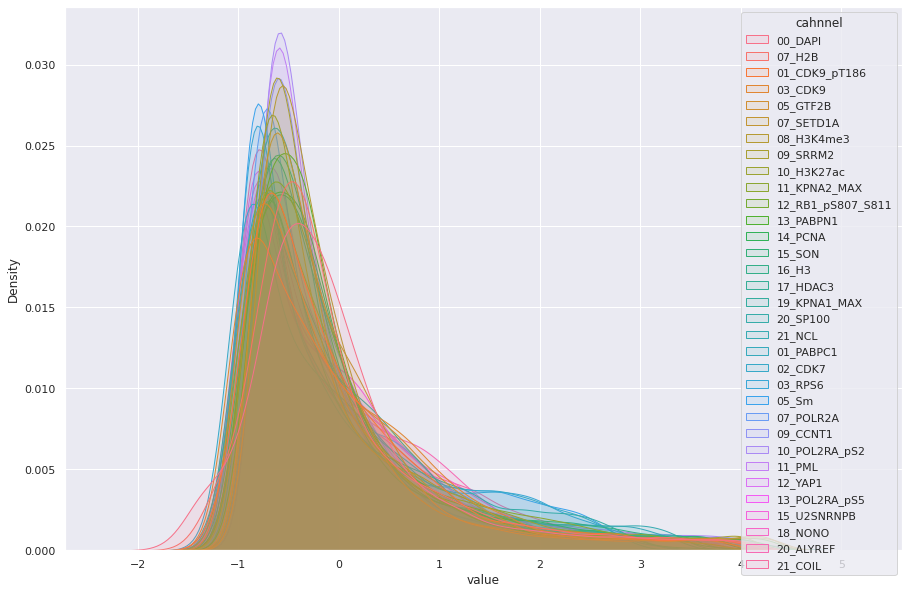

In [39]:
cell_id = '321001'
score_map = cells[cell_id+'_sm']
cell_mask = cells[cell_id+'_mask']
stddev = 1

score_map = preprocess_sm(score_map, cell_mask, stddev)
temp_df = pd.DataFrame(score_map[cell_mask], columns=input_channel_names)
temp_df = temp_df.stack()
temp_df = temp_df.reset_index()
temp_df = temp_df.drop(['level_0'], axis=1)
temp_df.columns = ['cahnnel', 'value']

plt.figure(figsize=(15,10))
sns.kdeplot(data=temp_df,
            x='value',
            hue='cahnnel',
            shade=True,
            alpha=0.1
           )

/home/hhughes/.local/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/hhughes/.local/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/hhughes/.local/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


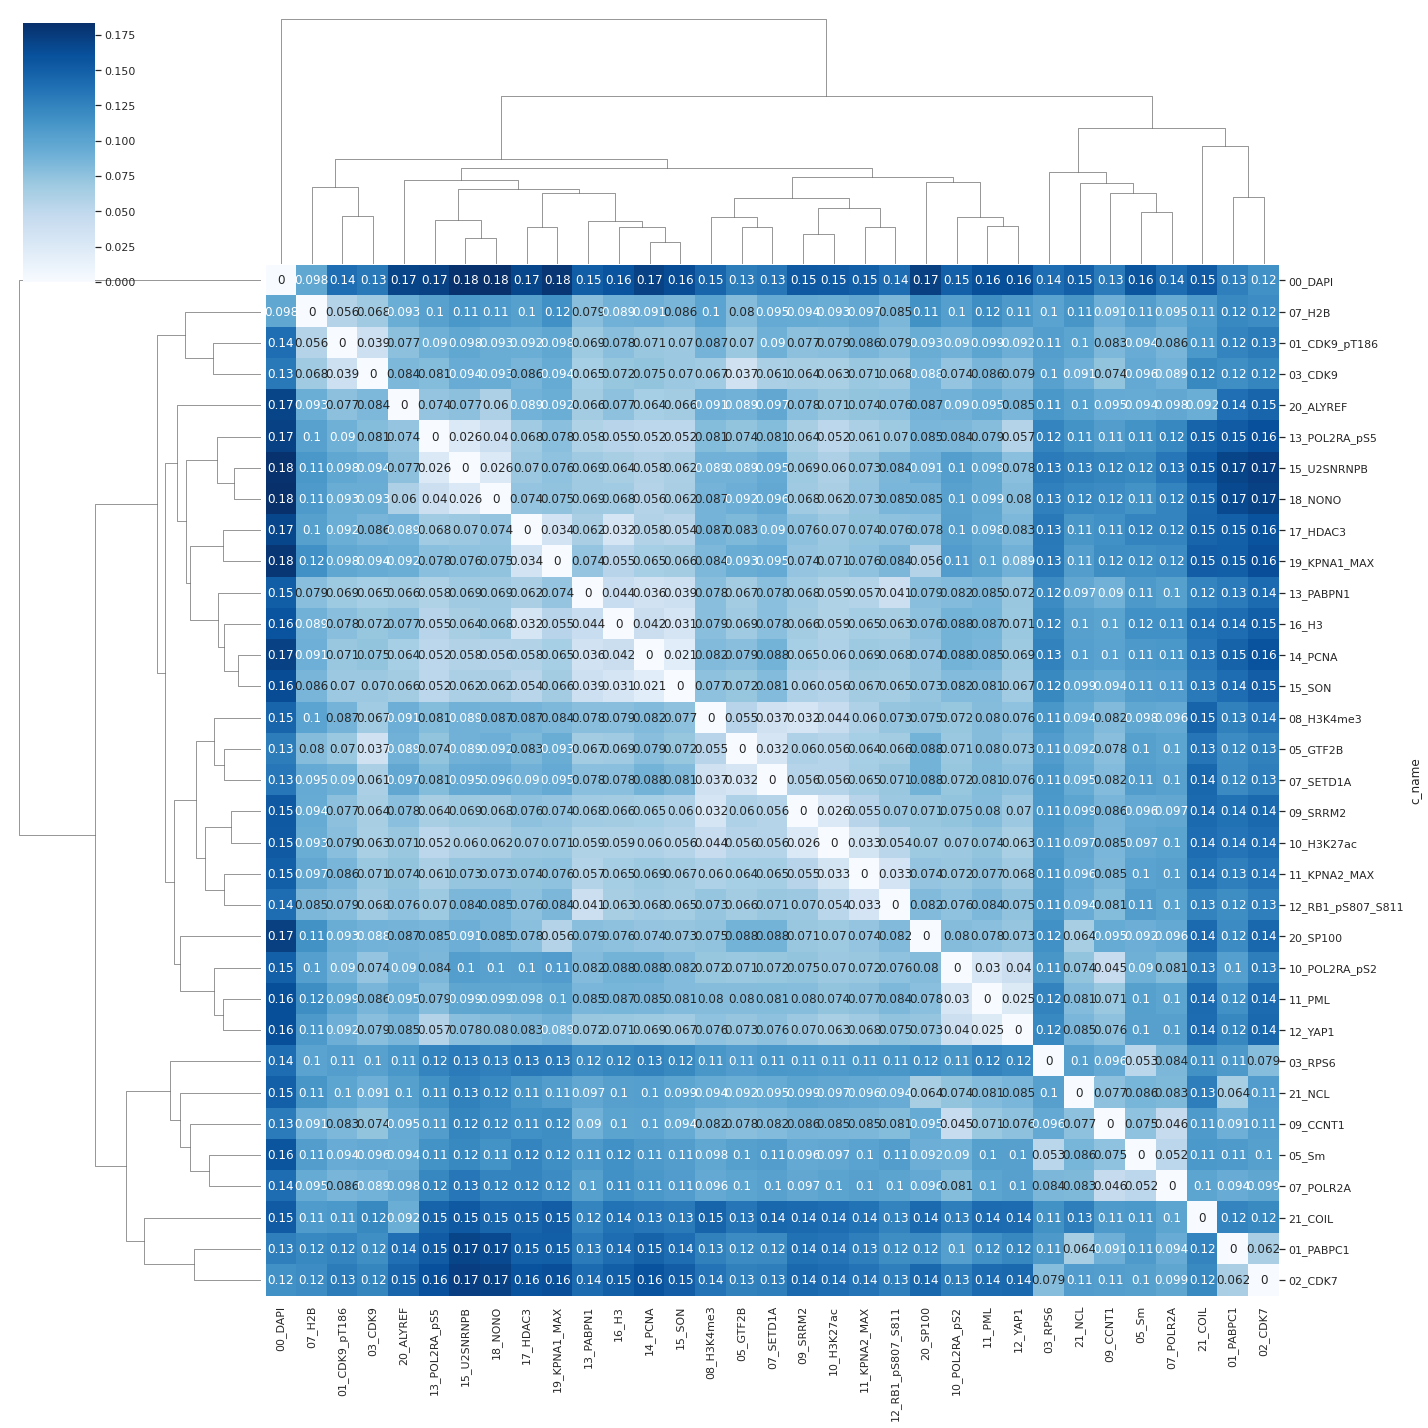

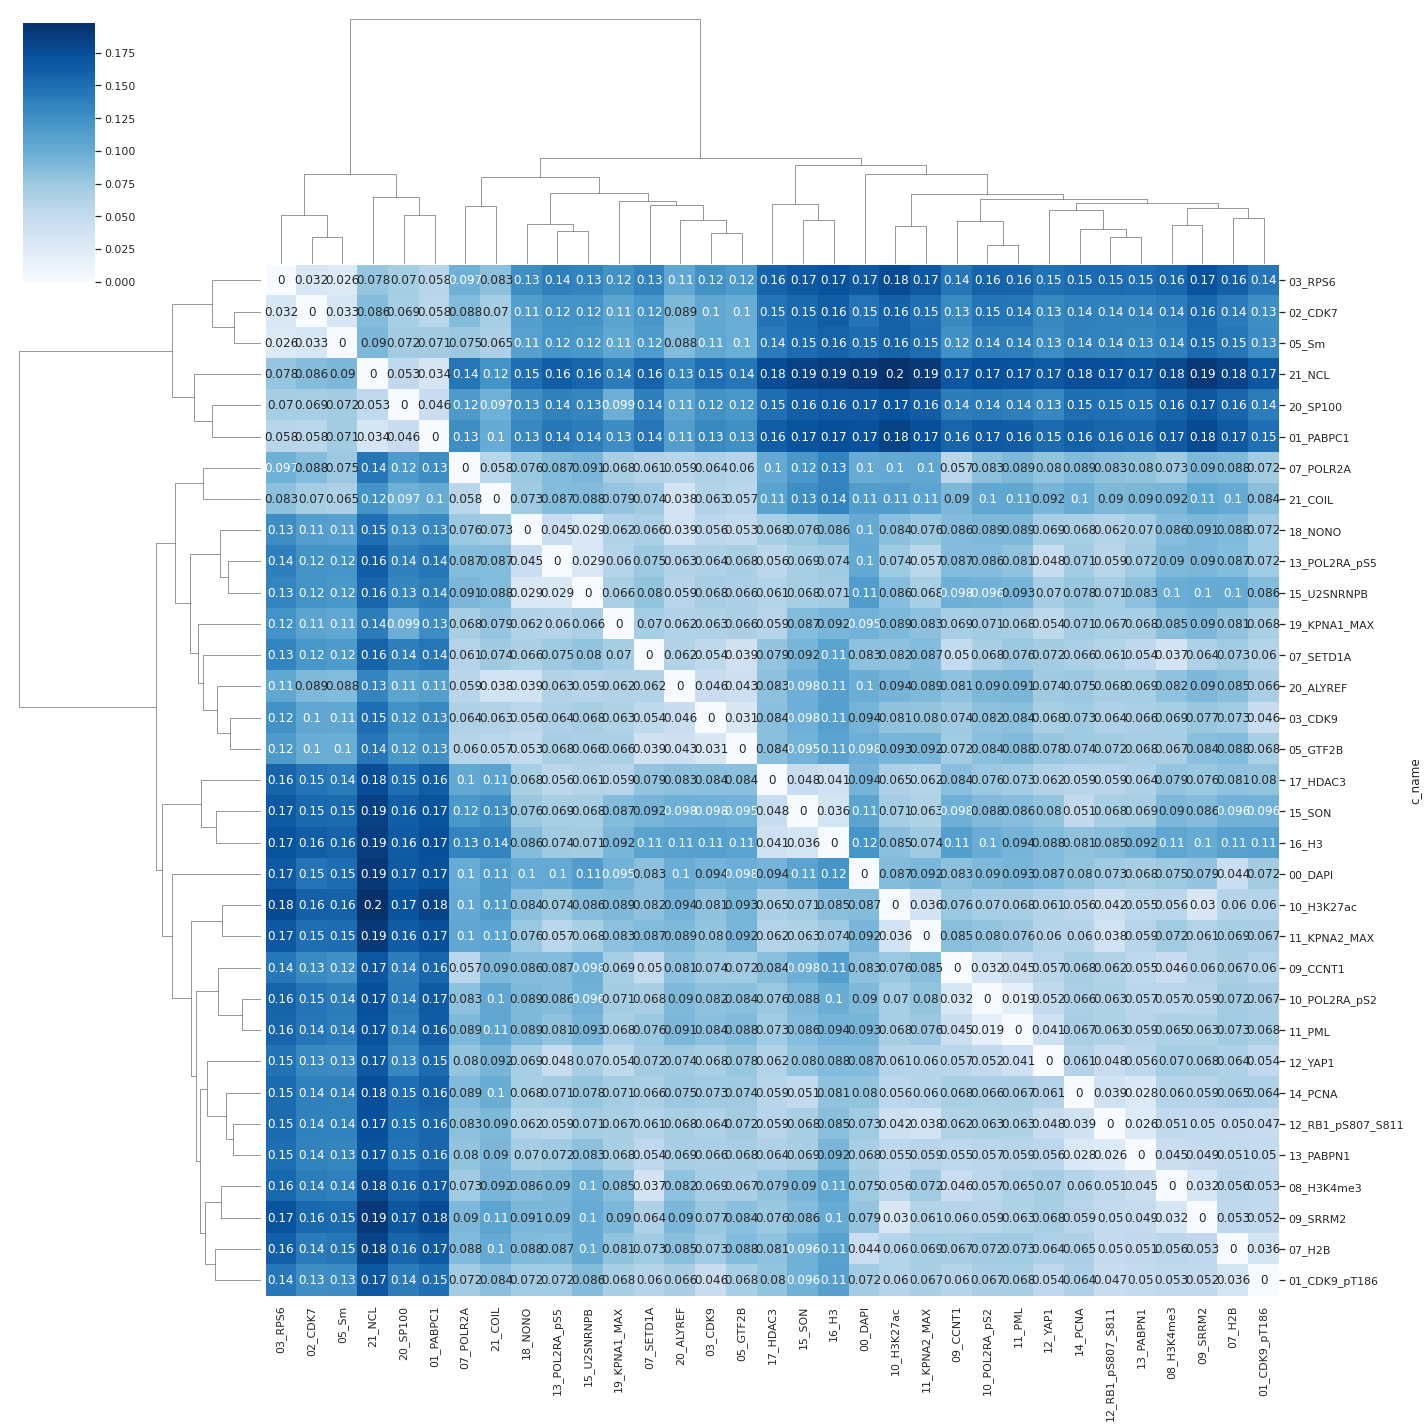

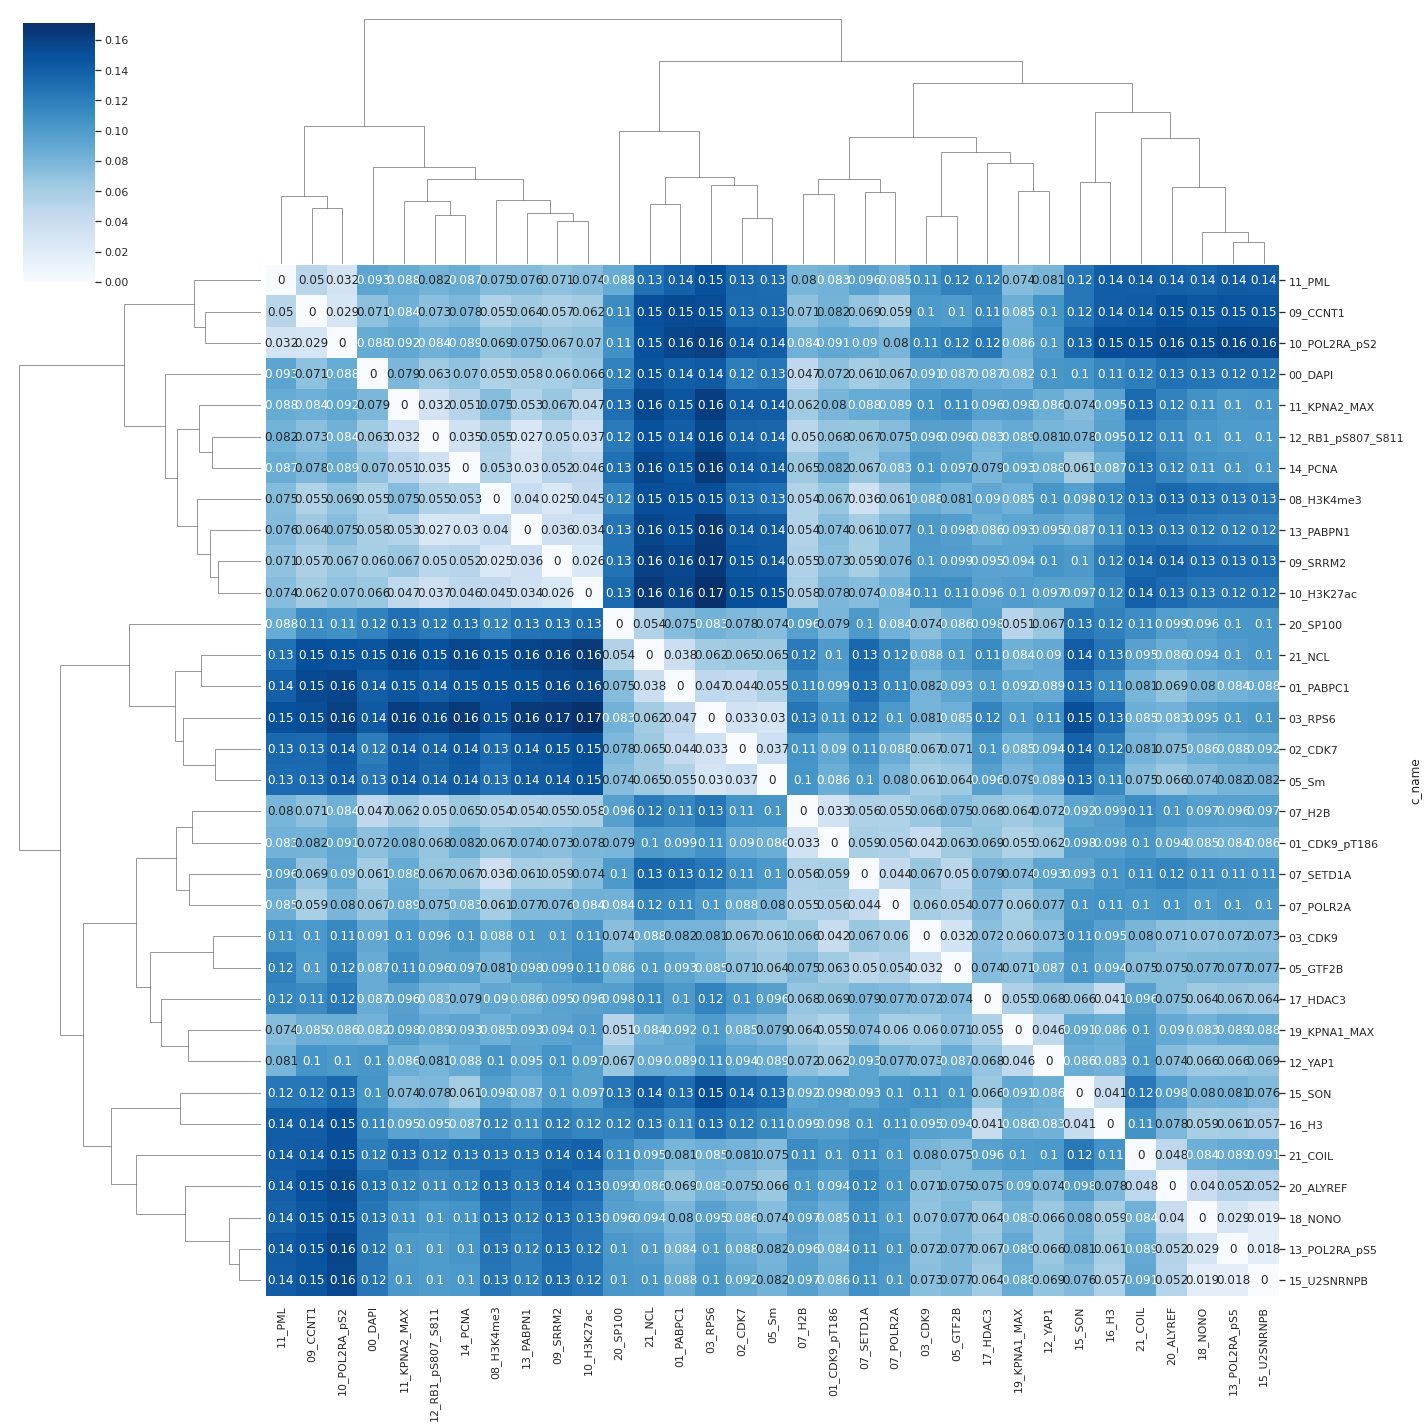

In [45]:
for cell_id in final_ids:
    mask = distance_df.mapobject_id_cell == int(cell_id)
    dist_mtx = distance_df[mask][input_channel_names]
    #dist_mtx = compute_channel_difference_matrix(temp_score, cell_mask, metric='mae')
    plot_clustermap(100*dist_mtx, channels_df)

In [ ]:
TODO: PRIMERO SACA LOS CLUSTER POR TR LEVEL

In [57]:
distance_df

,00_DAPI,07_H2B,01_CDK9_pT186,03_CDK9,05_GTF2B,07_SETD1A,08_H3K4me3,09_SRRM2,10_H3K27ac,11_KPNA2_MAX,12_RB1_pS807_S811,13_PABPN1,14_PCNA,15_SON,16_H3,17_HDAC3,19_KPNA1_MAX,20_SP100,21_NCL,01_PABPC1,02_CDK7,03_RPS6,05_Sm,07_POLR2A,09_CCNT1,10_POL2RA_pS2,11_PML,12_YAP1,13_POL2RA_pS5,15_U2SNRNPB,18_NONO,20_ALYREF,21_COIL,mapobject_id_cell,TR_Level,cell_cycle
0,0.000000,0.000379,0.000525,0.000612,0.000626,0.000638,0.000592,0.000523,0.000843,0.000958,0.000503,0.000491,0.000609,0.000949,0.001114,0.000767,0.000787,0.001474,0.001843,0.001436,0.001178,0.001413,0.001223,0.000849,0.000730,0.000742,0.000750,0.000806,0.001111,0.001065,0.000819,0.000783,0.000866,305670,NaN,NaN
1,0.000379,0.000000,0.000266,0.000529,0.000658,0.000714,0.000664,0.000506,0.000707,0.000796,0.000371,0.000506,0.000568,0.000862,0.001008,0.000672,0.000718,0.001401,0.001728,0.001332,0.001138,0.001367,0.001197,0.000878,0.000777,0.000761,0.000739,0.000643,0.000925,0.000902,0.000677,0.000688,0.000828,305670,NaN,NaN
2,0.000525,0.000266,0.000000,0.000372,0.000545,0.000668,0.000645,0.000515,0.000786,0.000865,0.000426,0.000502,0.000546,0.000873,0.001043,0.000678,0.000628,0.001286,0.001633,0.001229,0.001032,0.001250,0.001075,0.000794,0.000731,0.000705,0.000662,0.000597,0.000921,0.000875,0.000643,0.000640,0.000780,305670,NaN,NaN
3,0.000612,0.000529,0.000372,0.000000,0.000295,0.000568,0.000607,0.000565,0.000838,0.000908,0.000507,0.000542,0.000528,0.000782,0.001003,0.000670,0.000618,0.001275,0.001630,0.001224,0.001014,0.001228,0.001025,0.000745,0.000732,0.000714,0.000639,0.000583,0.000888,0.000809,0.000568,0.000593,0.000764,305670,NaN,NaN
4,0.000626,0.000658,0.000545,0.000295,0.000000,0.000341,0.000448,0.000576,0.000936,0.001030,0.000565,0.000517,0.000520,0.000813,0.001094,0.000780,0.000674,0.001339,0.001765,0.001341,0.001041,0.001236,0.000996,0.000637,0.000624,0.000641,0.000621,0.000727,0.001015,0.000912,0.000616,0.000624,0.000759,305670,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000762,0.001004,0.001047,0.000831,0.000738,0.000947,0.001125,0.001026,0.000634,0.000525,0.000724,0.000885,0.000703,0.000538,0.000553,0.000398,0.000689,0.001257,0.001487,0.001285,0.001139,0.001310,0.001303,0.001303,0.001264,0.001174,0.001065,0.000619,0.000000,0.000277,0.000592,0.000790,0.001168,224150,NaN,NaN
122195,0.000669,0.000870,0.000899,0.000696,0.000594,0.000772,0.000975,0.000912,0.000629,0.000672,0.000651,0.000803,0.000655,0.000677,0.000747,0.000483,0.000646,0.001203,0.001442,0.001227,0.001044,0.001197,0.001137,0.001139,0.001152,0.001096,0.001033,0.000681,0.000277,0.000000,0.000355,0.000668,0.001078,224150,NaN,NaN
122196,0.000545,0.000650,0.000671,0.000473,0.000442,0.000572,0.000785,0.000757,0.000729,0.000887,0.000624,0.000693,0.000673,0.000930,0.001037,0.000649,0.000554,0.001071,0.001347,0.001142,0.000893,0.001023,0.000887,0.000885,0.000939,0.000908,0.000886,0.000667,0.000592,0.000355,0.000000,0.000424,0.000871,224150,NaN,NaN
122197,0.000662,0.000794,0.000823,0.000559,0.000509,0.000724,0.000920,0.000869,0.000820,0.000915,0.000641,0.000701,0.000700,0.001018,0.001142,0.000803,0.000686,0.001023,0.001331,0.001157,0.000926,0.001059,0.000935,0.001008,0.001004,0.000934,0.000911,0.000738,0.000790,0.000668,0.000424,0.000000,0.000486,224150,NaN,NaN


In [62]:
# add transcription level to the distance matrices
distance_df = distance_df.merge(targets_df[['mapobject_id_cell', 'TR_Level', 'cell_cycle']],
                  left_on='mapobject_id_cell',
                  right_on='mapobject_id_cell',
                  how='left'
                 )

In [63]:
mask = distance_df.TR_Level == 'Low_TR'
X_low = distance_df[mask][input_channel_names].values
X_low = X_low.T

mask = distance_df.TR_Level == 'Medium_TR'
X_avg = distance_df[mask][input_channel_names].values
X_avg = X_avg.T

mask = distance_df.TR_Level == 'High_TR'
X_high = distance_df[mask][input_channel_names].values
X_high = X_high.T

X = distance_df[input_channel_names].values
X = X.T

In [64]:
# Create DataFrame to save clusters
clusters_ids_df = pd.DataFrame(input_channel_names, columns=['channel_name'])

In [65]:
X_low

array([[0.        , 0.00058886, 0.00082965, ..., 0.00074063, 0.00090247,
        0.00109511],
       [0.00058886, 0.        , 0.00033066, ..., 0.00066269, 0.00082163,
        0.00100974],
       [0.00082965, 0.00033066, 0.        , ..., 0.00062239, 0.00072592,
        0.0009079 ],
       ...,
       [0.00082288, 0.00074206, 0.00078378, ..., 0.        , 0.00038414,
        0.00072881],
       [0.00082015, 0.00067122, 0.00069968, ..., 0.00038414, 0.        ,
        0.00037072],
       [0.00093165, 0.00076173, 0.00080153, ..., 0.00072881, 0.00037072,
        0.        ]])

# K-mean

In [66]:
from sklearn.cluster import KMeans

n_channels = X.shape[0]
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
X_clusters = kmeans.labels_
clusters_ids_df['k_means'] = X_clusters
X_clusters

array([2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0], dtype=int32)

In [71]:
# Create DataFrame to save clusters
temp_clusters = pd.DataFrame(input_channel_names, columns=['channel_name'])

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_low)
temp_clusters['X_low'] = kmeans.labels_

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_avg)
temp_clusters['X_medium'] = kmeans.labels_

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_high)
temp_clusters['X_high'] = kmeans.labels_

In [72]:
temp_clusters.sort_values(by=['X_low', 'X_medium', 'X_high'])

,channel_name,X_low,X_medium,X_high
5,07_SETD1A,0,0,0
6,08_H3K4me3,0,0,0
23,07_POLR2A,0,0,0
24,09_CCNT1,0,0,0
25,10_POL2RA_pS2,0,0,0
26,11_PML,0,0,0
3,03_CDK9,0,0,2
4,05_GTF2B,0,0,2
16,19_KPNA1_MAX,0,0,2
31,20_ALYREF,0,0,2


In [74]:
cell_id_2 = '195536'
for cell_id in cell_id_2:
    print('\n\n', cell_id)
    score_map = cells[cell_id+'_sm']
    cell_img = cells[cell_id+'_img']
    cell_mask = cells[cell_id+'_mask']

    temp_score = copy.deepcopy(score_map)
    temp_score = preprocess_sm(temp_score, cell_mask, stddev)
    temp_img = copy.deepcopy(cell_img)
    temp_img = preprocess_img(temp_img, cell_mask, stddev)

    for c in range(n_clusters):
        mask = (clusters == c)
        cluster_channel_ids = np.arange(n_channels)[mask]
        
        plt_name = './Plot/cluster_'+'kmeans_'+str(cell_id)+'_'+str(c)+'.jpg'

        channels_2_plot = np.arange(n_channels)[mask]
        nn_inter.plot_VarGrad_IG_2(img=temp_img,
                                img_mask=cell_mask,
                                       score_maps={'BL_RIV2_test4': temp_score},
                                       top_percent=1,
                                       channels_df=channels_df,
                                       img_size=(7,7),
                                       score_map_same_sacale=False,
                                       channels_2_plot=channels_2_plot,
                                       plot_overlap=False,
                                       plot_colorbar=False,
                                       plot_name=plt_name,#None,
                                      )



 1


KeyError: '1_sm'